In [2]:
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import numpy as np
import imutils
import cv2
import os

In [3]:
#initialize min prob to filter weak detections along with the threshold when applying non-maxima suppression
MIN_CONF=0.3
NMS_THRESH=0.3

In [20]:
def detect_people(frame,net,ln,personIdx=0):
    #grab the dimensions of the frame and initialise the list of results
    (H,W)=frame.shape[:2]
    results=[]
    #construct a blob from the i/p frame and then perform a forward pass of the YOLO object detector, giving us our bounding boxes and associated probabilities
    blob=cv2.dnn.blobFromImage(frame,1/255.0,(416,416),swapRB=True,crop=False)
    net.setInput(blob)
    layerOutputs=net.forward(ln)
    #initialise our lists of detecting bounding boxes,centroids,and confidences resp
    boxes=[]
    centroids=[]
    confidences=[]
    
    for output in layerOutputs:
        for detection in output:
            #extract the class ID and confidence(i.e ,probability) of the current object detection
            scores=detection[5:]
            classID=np.argmax(scores)
            confidence=scores[classID]
            
            #filter the detections by (1) ensuring that the object detected  was a person and that the min confidence is met
            if classID==personIdx and confidence>MIN_CONF:
                #SCALE THE BOUNDING BOX COORDINATES BACK RELATIVE TO THE SIZE OF THE IMAGE ,KEEPING IN MIND THAT YOLO ACTUALLY RETURNS THE CENTRE (x,y)-COORDINATES OF THE BOUNDING BOX FOLLOWED BY THE BOXES WIDTH AND HEIGHT
                box=detection[0:4]*np.array([W,H,W,H])
                (centerX,centerY,width,height)=box.astype("int")
                #use the center(x,y)-coordinates to derive the top and left corner of the bounding box
                x=int(centerX-(width/2))
                y=int(centerY-(height/2))
                
                #update our list of bounding box coordinates,centroids and confidences
                boxes.append([x,y,int(width),int(height)])
                centroids.append((centerX,centerY))
                confidences.append(float(confidence))
        #apply non-maxima suppression to suppress weak,overlapping bounding boxes
        idxs=cv2.dnn.NMSBoxes(boxes,confidences,MIN_CONF,NMS_THRESH)
        
        #ensure atleast one detection exist
        if len(idxs)>0:
            #loop over the indexes we are keeping
            for i in idxs.flatten():
                #extract the bounding box coordinates
                (x,y)=(boxes[i][0],boxes[i][1])
                (w,h)=(boxes[i][2],boxes[i][3])
                
                #update our results list to consist of the person prediction prob ,bounding box coordinates and the centroid
                r=(confidences[i],(x,y,x+w,y+h),centroids[i])
                results.append(r)
        return results

In [115]:
#boolean indicating if NVDIA CUDA GPU should be used
USE_GPU=False
#define the min safe distance(in pixels) that two people should maintain
MIN_DISTANCE=250
display=1

In [116]:
labelsPath='coco.names2.txt'
LABELS=open(labelsPath).read().strip().split('\n')
#LABELS

In [117]:
configPath='yolov3.cfg'
weightsPath='yolov3.weights'
print('Loading YOLO from disk...')
net=cv2.dnn.readNetFromDarknet(configPath,weightsPath)

Loading YOLO from disk...


In [118]:
#check if we are going to use GPU
if USE_GPU:
    #set CUDA as the preferable backwnd and target
    print('setting pref backend and target to CUDA...')
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [119]:
#determine only the o/p layer names that we need
ln=net.getLayerNames()
ln=[ln[i[0]-1] for i in net.getUnconnectedOutLayers()]


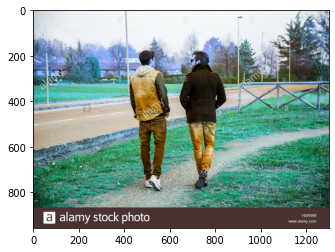

In [137]:
image='sd2.jpg'
frame=cv2.imread(image)
plt.imshow(frame)

In [138]:
#resize the frame and then detect people and (only people in it)
frame=imutils.resize(frame,width=700)
results = detect_people(frame, net, ln,
                        personIdx=LABELS.index("person"))

#initialise the set of indexes that violate the minimum social distance
violate=set()

In [139]:
#ensure there are atleast two people detections(required in order to compute our pairwise distance maps)
if len(results)>=2:
    #extract all the centroids ffrom the results and compute the Eucidean distances between all pairs of the centroids
    centroids=np.array([r[2] for r in results])
    D=dist.cdist(centroids,centroids,metric="euclidean")
    #loop over the upper triangle of the distance matrix
    for i in range(0,D.shape[0]):
        for j in range(i+1,D.shape[1]):
            #check to see if the dist b/w any 2 centroid pairs is less than the conf number
            if D[i,j] < MIN_DISTANCE:
                violate.add(i)
                violate.add(j)

In [140]:
for(i,(prob,bbox,centroid)) in enumerate(results):
    #extract the bbox and centroid coordinates then initialize the color of annotation
    (startX,startY,endX,endY)=bbox
    (cX,cY)=centroid
    color=(0,255,0)
    
    #if the index pair exists within the violation set,then update the color
    if i in violate:
        color=(0,0,255)
        
    #draw 1 bbox around the person and 2 centroid coordinates of the person
    cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
    cv2.circle(frame,(cX,cY),5,color,1)

In [141]:
text='social distancing violations: {}'.format(len(violate))
cv2.putText(frame,text,(10,frame.shape[0]-25),cv2.FONT_HERSHEY_COMPLEX,0.85,(0,0,255),3)
cv2.imshow('Frame',frame)
cv2.waitKey(0)==13
cv2.destroyAllWindows()

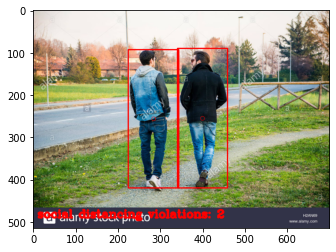

In [142]:
frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)